# Spark Project




---



## **1. Project Overview**
The goal of this project is to build a scalable Big Data pipeline using  Spark to analyze the evolution of fuel prices in France. The analysis covers the period from 2022 to 2024.


## **2. Configuration & Setup**
To ensure the code is modular and reproducible, we used a `config.yaml` file to manage global parameters so we can easily change the year range or data source.



In [ ]:
%%writefile config.yaml
# ---------------------------------------------------------
# This file controls the main parameters of the data pipeline.
# Changing values here will automatically update the download
# and processing logic.
# ---------------------------------------------------------

# File location
data_directory: "./data/"

# The time range
start_year: 2022
end_year: 2024

## The source link
base_url: "https://raw.githubusercontent.com/rvm-courses/GasPrices/master/"

Overwriting config.yaml


In [ ]:
import os

# Create the folder
os.makedirs('./data', exist_ok=True)

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, weekofyear, count, desc , min

## **3. Data Ingestion**
In this section we implied a function that download the data automatically   



In [ ]:
import requests
import yaml

def download_correct_data():
    """
    Reads config.yaml and downloads the required datasets.
    """

    # 1. Load Configuration
    with open("config.yaml", 'r') as f:
        config = yaml.safe_load(f)

    base_url = config['base_url']
    data_dir = config['data_directory']
    start_year = config['start_year']
    end_year = config['end_year']

    os.makedirs(data_dir, exist_ok=True)
    print(f"⬇️ Downloading corrected files to {data_dir}...\n")

    # 1. Generate the correct list of files based on your repo scan
    files_to_download = []

    # Add 2024 Metadata files
    files_to_download.append("Stations2024.csv.gz")
    files_to_download.append("Services2024.csv.gz")

    # Add Price files
    for year in range(start_year, end_year + 1):
        if year == 2022:
            # 2022 is split into Semester 1 and Semester 2
            files_to_download.append(f"Prix{year}S1.csv.gz")
            files_to_download.append(f"Prix{year}S2.csv.gz")
        else:
            files_to_download.append(f"Prix{year}.csv.gz")

    # 2. Download loop
    for filename in files_to_download:
        url = base_url + filename
        save_path = os.path.join(data_dir, filename)

        if not os.path.exists(save_path):
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    with open(save_path, 'wb') as f:
                        f.write(response.content)

                else:
                    url_main = url.replace("master", "main")
                    response = requests.get(url_main)
                    if response.status_code == 200:
                         with open(save_path, 'wb') as f:
                            f.write(response.content)
                    else:
                        print(f" Failed")
            except Exception as e:
                print(f" Error: {e}")
        else:
            print(f"   Skipping {filename} (already exists)")


download_correct_data()

⬇️ Downloading corrected files to ./data/...

   Skipping Stations2024.csv.gz (already exists)
   Skipping Services2024.csv.gz (already exists)
   Skipping Prix2022S1.csv.gz (already exists)
   Skipping Prix2022S2.csv.gz (already exists)
   Skipping Prix2023.csv.gz (already exists)
   Skipping Prix2024.csv.gz (already exists)


##**4.initializes a SparkSession**
This is the entry point for programming Spark with the Dataset and DataFrame API

In [ ]:
#set the spark session
spark= pyspark.sql.SparkSession.builder.appName('project').getOrCreate()


## **5. Data Preparation & Cleaning**
In this section we prepared the data and transformed it into a structured format suitable for analysis.
**Key Data Engineering Tasks:**
1. There is not any headers so We assign column names.
2. Coordinates are stored as integers so we divided them by $10^5$ to become standard decimal.
3.  We  splited `maj` into Year, Month, and Week columns.
4.  We remove uncommon fuels (`GPLc` , `E85` ) to focus only on the most popular ones.

In [ ]:
from pyspark.sql.functions import col, to_date, year, month, weekofyear
from pyspark.sql.types import DoubleType
#load data - 2 different for year 2022
# 1. Update paths
price_files = [
    "data/Prix2022S1.csv.gz",
    "data/Prix2022S2.csv.gz",
    "data/Prix2023.csv.gz",
    "data/Prix2024.csv.gz"
]

# 2. Read Data WITHOUT header
# We set header to "false" as Spark takes the first row as a header of data and we do not want it
df = spark.read.option("header", "false") \
               .option("inferSchema", "true") \
               .option("sep", ";") \
               .csv(price_files)

# 3. Rename Columns
df_renamed = df.toDF("id_pdv", "cp", "pop", "latitude", "longitude", "maj", "id_carburant", "nom", "valeur")

# 4. Transform & Clean
df_clean = df_renamed.withColumn("date_parsed", to_date(col("maj"))) \
    .withColumn("year", year(col("date_parsed"))) \
    .withColumn("month", month(col("date_parsed"))) \
    .withColumn("week", weekofyear(col("date_parsed"))) \
    .withColumn("latitude", col("latitude").cast(DoubleType()) / 100000) \
    .withColumn("longitude", col("longitude").cast(DoubleType()) / 100000) \
    .filter(~col("nom").isin(["GPLc", "E85"]))

# 5. View Result
df_clean.createOrReplaceTempView("gas_prices")
df_clean.printSchema()
df_clean.show(5)

root
 |-- id_pdv: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- maj: timestamp (nullable = true)
 |-- id_carburant: integer (nullable = true)
 |-- nom: string (nullable = true)
 |-- valeur: double (nullable = true)
 |-- date_parsed: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)

+-------+----+---+--------+---------+-------------------+------------+------+------+-----------+----+-----+----+
| id_pdv|  cp|pop|latitude|longitude|                maj|id_carburant|   nom|valeur|date_parsed|year|month|week|
+-------+----+---+--------+---------+-------------------+------------+------+------+-----------+----+-----+----+
|1000001|1000|  R|  46.201|    5.198|2023-01-02 07:53:26|           1|Gazole| 1.867| 2023-01-02|2023|    1|   1|
|1000001|1000|  R|  46.201|    5.198|2023-0

## 6. Feature Engineering:
To compare price evolution across different years and fuel types, we compute two new features:

1.  Week Index: We count weeks continuously starting from 2022.
2.  Price Index (Base 100): we normalized the price. Instead of comparing raw prices (e.g., €1.80 vs €1.50), we compare the change.
    * Formula: Index = (Price / BasePrice) * 100
    * Value 100: Price is unchanged.
    * Value 110: Price has increased by 10%.
  

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, first, round

# 1. Compute Week Index
# Formula: (Year - 2022) * 52 + Week_Number
# This ensures Week 1 of 2022 is "1", and the count goes up to ~156 by end of 2024.
df_step2 = df_clean.withColumn("week_index", (col("year") - 2022) * 52 + col("week"))

# 2. Compute Price Index
# We define a "Window" to look at the history of EACH station (id_pdv) and EACH fuel (nom)
# We order by date so we can find the "first" price ever recorded.
window_spec = Window.partitionBy("id_pdv", "nom").orderBy("date_parsed")

# Logic: Index = (Current_Price / Base_Price) * 100
# If the price is the same as the start, Index = 100.
df_indices = df_step2.withColumn("base_price", first("valeur").over(window_spec)) \
                     .withColumn("price_index", round((col("valeur") / col("base_price")) * 100, 2))

# 3. Clean up & Register Table
# We remove the temporary "base_price" column to keep it clean
df_final_part2 = df_indices.drop("base_price")

df_final_part2.createOrReplaceTempView("gas_prices_indexed")


df_final_part2.select("id_pdv", "date_parsed", "nom", "valeur", "week_index", "price_index").show(10)

+-------+-----------+---+------+----------+-----------+
| id_pdv|date_parsed|nom|valeur|week_index|price_index|
+-------+-----------+---+------+----------+-----------+
|1000001| 2023-05-09|E10| 1.779|        71|      100.0|
|1000001| 2023-05-12|E10| 1.803|        71|     101.35|
|1000001| 2023-05-15|E10| 1.791|        72|     100.67|
|1000001| 2023-05-16|E10| 1.785|        72|     100.34|
|1000001| 2023-05-19|E10| 1.788|        72|     100.51|
|1000001| 2023-05-22|E10| 1.816|        73|     102.08|
|1000001| 2023-05-25|E10| 1.818|        73|     102.19|
|1000001| 2023-06-05|E10| 1.814|        75|     101.97|
|1000001| 2023-06-06|E10| 1.818|        75|     102.19|
|1000001| 2023-06-07|E10| 1.836|        75|      103.2|
+-------+-----------+---+------+----------+-----------+
only showing top 10 rows


## 7. Visualization: Weekly Price

1.  We group the data by `week_index` and `nom` (Gas Type) to calculate the average weekly price.
2.  *We use `sns.lineplot` to visualize the trends, with a distinct colored line for each fuel type.

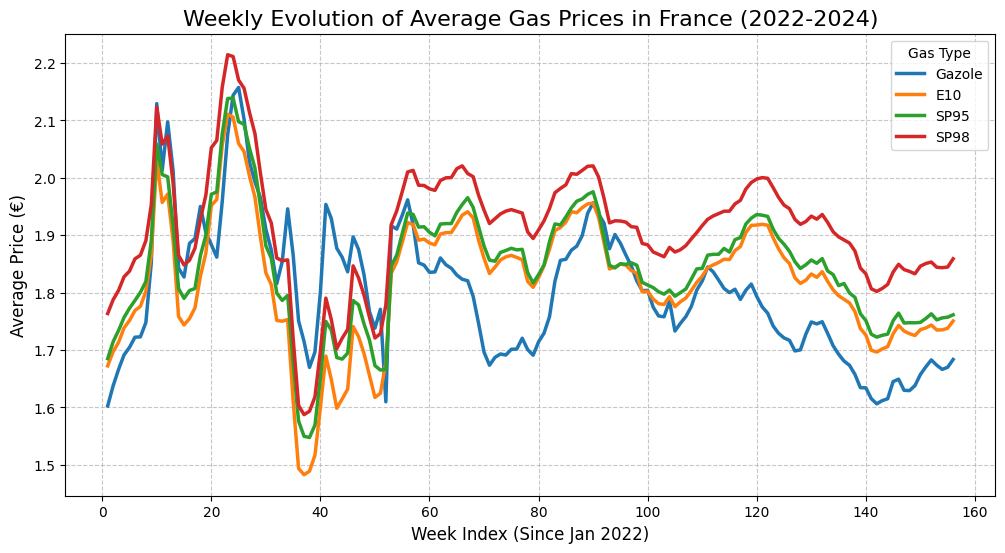

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg

# 1. Aggregate Data in Spark
# We calculate the average price for each gas type for every week
df_weekly_avg = df_final_part2.groupBy("week_index", "nom") \
                              .agg(avg("valeur").alias("avg_price")) \
                              .orderBy("week_index")

# 2. Convert to Pandas
pdf_weekly = df_weekly_avg.toPandas()

# 3. Plotting with Seaborn
plt.figure(figsize=(12, 6))


sns.lineplot(data=pdf_weekly, x="week_index", y="avg_price", hue="nom", linewidth=2.5)

plt.title("Weekly Evolution of Average Gas Prices in France (2022-2024)", fontsize=16)
plt.xlabel("Week Index (Since Jan 2022)", fontsize=12)
plt.ylabel("Average Price (€)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Gas Type")

plt.show()

## **8. Modeling Prep: Creating Lag Features**
we estimated by using a standard regression modelso we converted this time-series problem into a supervised learning problem.


We create "Lag Features"—columns that contain the price history for each specific row.
* Target (Label): The price *today*.
* Feature 1 (`lag_1`): The price *yesterday*.
* Feature 2 (`lag_7`): The price *7 days ago*

By doing this, the model learns patterns like: *"If the price was high yesterday and last week, it will likely be high today."*

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, dayofweek

# 1. Define the Window
# We group by Station and Gas Type, and order by Date
window_spec = Window.partitionBy("id_pdv", "nom").orderBy("date_parsed")

# 2. Create Lag Features (The "History" columns)
# lag_1: Price 1 day ago
# lag_2: Price 2 days ago
# lag_7: Price 7 days ago (captures weekly patterns)
df_features = df_clean.withColumn("lag_1", lag("valeur", 1).over(window_spec)) \
                      .withColumn("lag_2", lag("valeur", 2).over(window_spec)) \
                      .withColumn("lag_3", lag("valeur", 3).over(window_spec)) \
                      .withColumn("lag_7", lag("valeur", 7).over(window_spec))

# 3. Clean Data for ML
# We drop rows with nulls (the first 7 days of data for any station won't have a lag_7, so we can't use them)
df_model_data = df_features.na.drop()

print(f"Rows ready for modeling: {df_model_data.count()}")
df_model_data.select("date_parsed", "nom", "valeur", "lag_1", "lag_7").show(5)

Rows ready for modeling: 11970298
+-----------+---+------+-----+-----+
|date_parsed|nom|valeur|lag_1|lag_7|
+-----------+---+------+-----+-----+
| 2023-06-05|E10| 1.814|1.818|1.779|
| 2023-06-06|E10| 1.818|1.814|1.803|
| 2023-06-07|E10| 1.836|1.818|1.791|
| 2023-06-09|E10| 1.839|1.836|1.785|
| 2023-06-14|E10| 1.834|1.839|1.788|
+-----------+---+------+-----+-----+
only showing top 5 rows


## **9. Linear Regression**


1.  Spark ML algorithms require all input features in one single vector column so we did and named it `features`.
2.  split data into Train/Test : We split the dataset (80% Training, 20% Testing) to evaluate the model's performance on unseen data.


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Prepare Features Vector
# Spark ML requires all input features to be in one single column called a "Vector"
assembler = VectorAssembler(
    inputCols=["lag_1", "lag_2", "lag_3", "lag_7"],
    outputCol="features"
)

# 2. Split Data (Train vs Test)
# We use 80% of data to teach the model, and hide 20% to test it later.
train_data, test_data = df_model_data.randomSplit([0.8, 0.2], seed=42)

# 3. Define the Model
# Linear Regression is chosed
lr = LinearRegression(featuresCol="features", labelCol="valeur")

# 4. Train the Model (Fit)

model = lr.fit(assembler.transform(train_data))

# 5. Make Predictions on Test Data
predictions = model.transform(assembler.transform(test_data))

predictions.select("date_parsed", "valeur", "prediction").show(5)

+-----------+------+------------------+
|date_parsed|valeur|        prediction|
+-----------+------+------------------+
| 2023-06-07| 1.836|1.8178269198959742|
| 2023-06-16|  1.81|1.8189677591746014|
| 2023-06-19| 1.823|1.8201402550577195|
| 2023-06-26| 1.799|1.8198347744758279|
| 2023-07-12| 1.826|1.8240948817921072|
+-----------+------+------------------+
only showing top 5 rows


## **10. Model Evaluation & Visualization**
To assess the performance of our model, we computed RMSE and visualized the result:

1.  Quantitative Metric (RMSE): The Root Mean Squared Error measures the average difference between the predicted price and the actual price. A lower RMSE indicates a more accurate model.
2.  Visual Inspection (Dispersion Plot): We plot Predicted vs. Actual prices.
    

 Root Mean Squared Error (RMSE): 0.0508
   (Interpretation: The model is off by approximately 0.0508 euros on average)


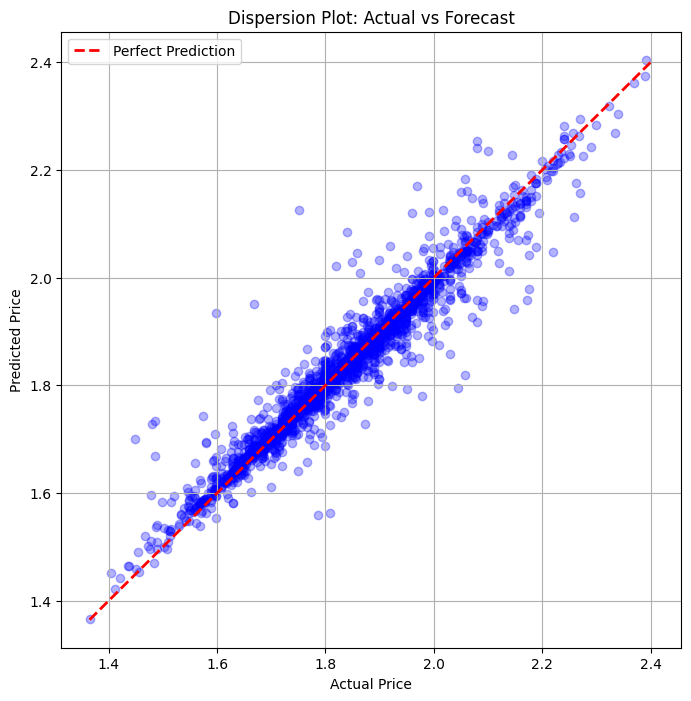

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Calculate Accuracy (RMSE)
evaluator = RegressionEvaluator(labelCol="valeur", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f" Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   (Interpretation: The model is off by approximately {rmse:.4f} euros on average)")

# 2. Visualization (Dispersion Plot)
# We take a sample because plotting millions of points will crash Colab

sample_pd = predictions.select("valeur", "prediction").sample(False, 0.001, seed=42).toPandas()

plt.figure(figsize=(8, 8))
plt.scatter(sample_pd["valeur"], sample_pd["prediction"], alpha=0.3, color='blue')

# Add a red line representing "Perfect Prediction" (x = y)
min_val = np.min([sample_pd["valeur"].min(), sample_pd["prediction"].min()])
max_val = np.max([sample_pd["valeur"].max(), sample_pd["prediction"].max()])plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Dispersion Plot: Actual vs Forecast")
plt.legend()
plt.grid(True)
plt.show()